In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# In depth with linear models

Linear models are useful when little data is available or for very large feature spaces, as in text classification. In addition, they form a good case study for regularization.

## Linear models for regression

All linear models for regression learn a coefficient parameter ``coef_`` and an offset ``intercept_`` to make predictions using a linear combination of features:
```
y_pred = x_test[0] * coef_[0] + ... + x_test[n_features-1] * coef_[n_features-1] + intercept_
```

The difference between the linear models for regression is what kind of restrictions are put on ``coef_`` and ``intercept_`` (know as regularization), in addition to fitting the training data well.

The most standard linear model is the 'ordinary least squares regression', often simply called 'linear regression'. It doesn't put any additional restrictions on ``coef_``, so when the number of features is large, it becomes ill-posed and the model overfits.

Let us generate a simple simulation, to see the behavior of these models.

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


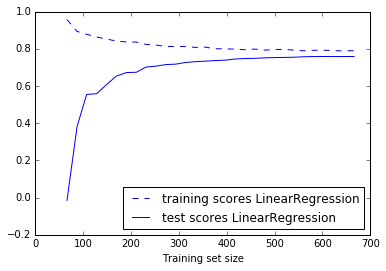

In [2]:
rng = np.random.RandomState(4)
X = rng.normal(size=(1000, 50))
beta = rng.normal(size=50)
y = np.dot(X, beta) + 4 * rng.normal(size=1000)

from sklearn.utils import shuffle
X, y = shuffle(X, y)

from sklearn import linear_model, cross_validation
from sklearn.learning_curve import learning_curve

def plot_learning_curve(est, X, y):
    training_set_size, train_scores, test_scores = learning_curve(est, X, y, train_sizes=np.linspace(.1, 1, 30))
    estimator_name = est.__class__.__name__
    line = plt.plot(training_set_size, train_scores.mean(axis=1), '--', label="training scores " + estimator_name)
    plt.plot(training_set_size, test_scores.mean(axis=1), '-', label="test scores " + estimator_name, c=line[0].get_color())
    plt.xlabel('Training set size')
    plt.legend(loc='best')
    #plt.ylim(-1, 1)
    
plot_learning_curve(linear_model.LinearRegression(), X, y)

As we can see, the ordinary linear regression is not defined if there are less training samples than features. In the presence of noise, it does poorly as long as the number of samples is not several times the number of features.

The LinearRegression is then overfitting: fitting noise. We need to regularize.

**The Ridge estimator** is a simple regularization (called l2 penalty) of the ordinary LinearRegression. In particular, it has the benefit of being not computationally more expensive than the ordinary least square estimate.

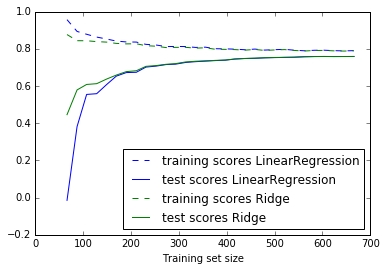

In [3]:
plot_learning_curve(linear_model.LinearRegression(), X, y)
plot_learning_curve(linear_model.Ridge(alpha=20), X, y)

We can see that in the low-sample limit, the Ridge estimator performs much better than the unregularized model.

The regularization of the Ridge is a shrinkage: the coefficients learned are biased towards zero. Too much bias is not beneficial, but with very few samples, we will need more bias.

The amount of regularization is set via the `alpha` parameter of the Ridge. Tuning it is critical for performance. We can set it automatically by cross-validation using the RidgeCV estimator:

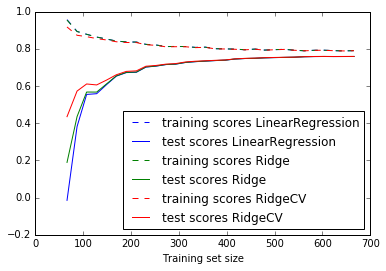

In [4]:
plot_learning_curve(linear_model.LinearRegression(), X, y)
plot_learning_curve(linear_model.Ridge(), X, y)
plot_learning_curve(linear_model.RidgeCV(), X, y)

**The Lasso estimator** is useful to impose sparsity on the coefficient. In other words, it is to be prefered if we believe that many of the features are not relevant. This is done via the so-called l1 penalty.

Let us create such a situation with a new simulation where only 10 out of the 50 features are relevant:

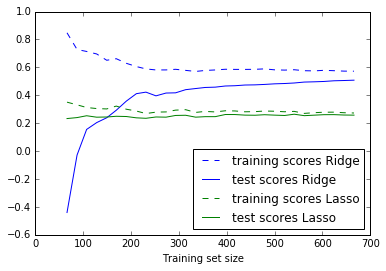

In [5]:
beta[10:] = 0
y = np.dot(X, beta) + 4*rng.normal(size=1000)
plot_learning_curve(linear_model.Ridge(), X, y)
plot_learning_curve(linear_model.Lasso(), X, y)

We can see that the Lasso estimator performs, in our case, better than the Ridge when there are a small number of training observations. However when there are a lot of observations the Lasso under-performs. Indeed, the variance-reducing effect of the regularization is less critical in these situations, and the bias becomes too detrimental.

As with any estimator, we should tune the regularization parameter to get the best prediction. For this purpose, we can use the LassoCV object. Note that it is a significantly more computationally costly operation than the RidgeCV. To speed it up, we reduce the number of values explored for the alpha parameter.

/usr/local/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


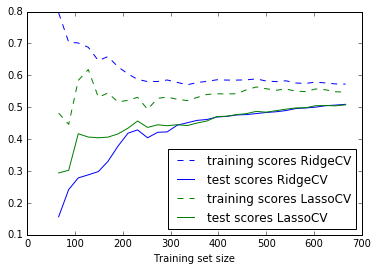

In [6]:
plot_learning_curve(linear_model.RidgeCV(), X, y)
plot_learning_curve(linear_model.LassoCV(n_alphas=20), X, y)

**ElasticNet** sits in between Lasso and Ridge. It has a tuning parameter, l1_ratio, that controls this behavior: when set to 0 (only l2 penalty), ElasticNet is a Ridge, when set to 1 (only l1 penalty), it is a Lasso. It is useful when your coefficients are not that sparse. The sparser the coefficients, the higher we should set l1_ratio. Note that l1_ratio can also be set by cross-validation, although we won't do it here to limit computational cost.

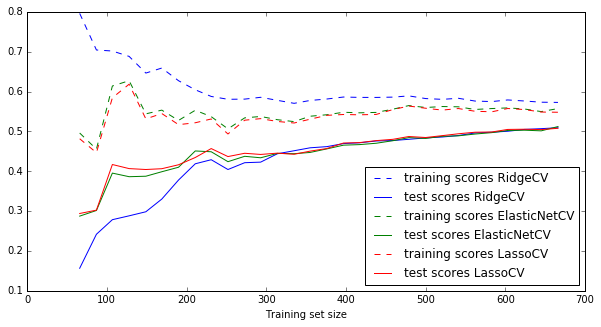

In [7]:
plt.figure(figsize=(10, 5))
plot_learning_curve(linear_model.RidgeCV(), X, y)
plot_learning_curve(linear_model.ElasticNetCV(l1_ratio=.6, n_alphas=20), X, y)
plot_learning_curve(linear_model.LassoCV(n_alphas=20), X, y)


#Exercise
Find the best linear regression prediction on the `diabetes` dataset, that is available in the scikit-learn datasets.

## Linear models for classification

All linear models for classification learn a coefficient parameter ``coef_`` and an offset ``intercept_`` to make predictions using a linear combination of features:
```
y_pred = x_test[0] * coef_[0] + ... + x_test[n_features-1] * coef_[n_features-1] + intercept_ > 0
```
As you can see, this is very similar to regression, only that a threshold at zero is applied.

Again, the difference between the linear models for classification what kind of regularization is put on ``coef_`` and ``intercept_``, but there are also minor differences in how the fit to the training set is measured (the so-called loss function).

The two most common models for linear classification are the linear SVM as implemented in LinearSVC and LogisticRegression.


**Regularization**: the linear classifiers can suffer from over-fit in the presence of many features and must be regularized. The 'C' parameter controls that regularization: large C values give unregularized model, while small C give strongly regularized models.

A good intuition for regularization of linear classifiers is that with high regularization, it is enough if most of the points are classified correctly. But with less regularization, more importance is given to each individual data point.
This is illustrated using an linear SVM with different values of ``C`` below.


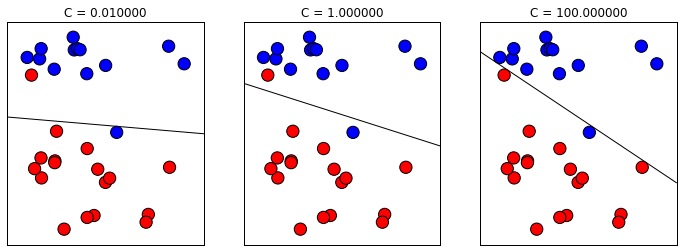

In [8]:
from figures import plot_linear_svc_regularization
plot_linear_svc_regularization()


Similar to the Ridge/Lasso separation, you can set the 'penalty' parameter to 'l1' to enforce sparsity of the coefficients.


#Exercise
Use LogisticRegression to classify digits, and grid-search the C parameter.

In [2]:
from sklearn.linear_model import LogisticRegression
params={'C':[0.001,0.1,10.0,1.0,0.01]}

from sklearn.grid_search import GridSearchCV
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split

digits=load_digits()
X_train,X_test,Y_train,Y_test=train_test_split(digits.data,digits.target)
grid=GridSearchCV(LogisticRegression(),param_grid=params)
grid.fit(X_train,Y_train)
grid.score(X_test,Y_test)

0.9622222222222222